In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore', module='pandas', category=UserWarning)

In [5]:
df = pd.read_csv("car_price.csv")
df

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats
...,...,...,...,...,...,...,...,...,...,...
5507,5507,BMW X1 sDrive 20d xLine,28.90 Lakh,"45,000 kms",Diesel,Automatic,1st Owner,2018,2995 cc,7 Seats
5508,5508,BMW M Series M4 Coupe,64.90 Lakh,"29,000 kms",Petrol,Automatic,2nd Owner,2015,1968 cc,5 Seats
5509,5509,Jaguar XF 2.2 Litre Luxury,13.75 Lakh,"90,000 kms",Diesel,Automatic,2nd Owner,2013,2755 cc,5 Seats
5510,5510,BMW 7 Series 730Ld,29.90 Lakh,"79,000 kms",Diesel,Automatic,3rd Owner,2015,2967 cc,6 Seats


In [6]:
df = df.drop("Unnamed: 0", axis=1)

In [7]:
df = df.rename(columns={"Seats": "seats"})

Checking null values

In [8]:
df.loc[df.isna().any(axis=1)]

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,seats


Duplicates

In [9]:
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
print(df["car_prices_in_rupee"].str.extract(r"([a-zA-Z]+)")[0].unique())

print(df["kms_driven"].str.extract(r"([a-zA-Z]+)")[0].unique())

print(df["fuel_type"].unique())

print(df["engine"].str.extract(r"([a-zA-Z]+)")[0].unique())
print(df["transmission"].unique())

print(df["ownership"].unique())

print(df["seats"].str.extract(r"([a-zA-Z]+)")[0].unique())

['Lakh' 'Crore' nan]
['kms']
['Diesel' 'Petrol' 'Cng' 'Electric' 'Lpg']
['cc']
['Manual' 'Automatic']
['1st Owner' '2nd Owner' '3rd Owner' '4th Owner' '5th Owner' '0th Owner']
['Seats']


In [11]:
df.ownership.value_counts()

ownership
1st Owner    3678
2nd Owner    1298
3rd Owner     358
4th Owner      84
5th Owner      12
0th Owner       6
Name: count, dtype: int64

Don't need 0th owner (Unused car)

In [12]:
df = df.drop(df[df["ownership"] == "0th Owner"].index)

Rupee to Euro

In [13]:
def rupee_to_euro(price): # 1 rupee = 0.01123 euro
    price = price.replace(",", ".")
    if("Lakh" in price):
        return float(price.replace(" Lakh", ""))  * 100000 * 0.01123
    elif("Crore" in price):
        return float(price.replace(" Crore", "").replace(",", ".")) * 10000000 * 0.01123
    else:
        return float(price)


df["car_prices_in_rupee"] = df["car_prices_in_rupee"].apply(rupee_to_euro)

In [14]:
df = df.rename(columns={"car_prices_in_rupee": "price_euro"})

objects to numerical

In [15]:
def convert_kms(kms):
    kms = kms.replace(" kms", "")
    return float(kms.replace(",", ""))

df["kms_driven"] = df["kms_driven"].apply(convert_kms)

In [16]:
df["ownership"] = df["ownership"].str.replace(r"(st|nd|rd|th) Owner", "", regex=True).astype(int)
df["engine"] = df["engine"].str.replace(" cc", "").astype(int)
df["seats"] = df["seats"].str.replace(" Seats", "").astype(float)

In [17]:
df.describe()

,price_euro,kms_driven,ownership,manufacture,engine,seats
count,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000
mean,12889.047262,63403.562063,1.426151,2015.430755,1532.948435,5.252486
std,21934.023630,41944.874143,0.704155,3.934616,581.131903,0.722866
min,35.000000,250.000000,1.000000,1995.000000,0.000000,2.000000
25%,3514.990000,33500.000000,1.000000,2013.000000,1197.000000,5.000000
50%,6176.500000,59319.500000,1.000000,2016.000000,1396.000000,5.000000
75%,11378.797500,84470.250000,2.000000,2018.000000,1950.000000,5.000000
max,215616.000000,560000.000000,5.000000,2022.000000,5950.000000,8.000000


Engine should not be 0

In [18]:
df = df.drop(df[df["engine"] == 0].index)

Check relationship between price and [kms_driven, fuel_type, transmission, ownership, manufacture, engine, seats]

In [19]:
df.groupby("transmission")["price_euro"].agg(["mean"])

,mean
transmission,
Automatic,31717.002450
Manual,5645.486115


In [20]:
print(df[df["transmission"] == "Automatic"].shape[0])
print(df[df["transmission"] == "Manual"].shape[0])

1506
3912


In [21]:
df.groupby("fuel_type")["price_euro"].agg(["mean"]).sort_values(by="mean")

,mean
fuel_type,
Lpg,1595.695643
Cng,4492.982625
Petrol,9846.662356
Electric,16951.685000
Diesel,17036.469472


In [22]:
df.groupby("ownership")["price_euro"].agg(["mean"]).sort_values(by="mean")

,mean
ownership,
5,1992.719500
4,3016.940393
3,4674.986620
2,9443.205443
1,15178.037607


In [23]:
df.groupby("manufacture")["price_euro"].agg(["mean"]).sort_values(by="mean")

,mean
manufacture,
1999,35.000000
2000,47.250000
2003,491.084125
1998,647.650000
2001,1022.625000
2002,1043.138462
2005,1314.549536
2004,1397.190625
2008,1631.583894


In [24]:
df.groupby("engine")["price_euro"].agg(["mean"]).sort_values(by="mean")

,mean
engine,
1390,1454.045333
2446,1459.900000
3498,1684.500000
1173,2246.000000
1242,2358.300000
...,...
2596,54746.250000
2359,67941.500000
4134,82540.500000


In [25]:
df.groupby("seats")["price_euro"].agg(["mean"]).sort_values(by="mean")

,mean
seats,
8.0,7838.870574
6.0,12034.629500
5.0,12529.210245
2.0,14363.170000
7.0,14860.878294
4.0,21440.313864


Categorize engine

In [26]:
df["engine_cat"] = pd.cut(df["engine"], bins=[600, 1200, 2000, np.inf], labels=["low", "medium", "high"])

In [27]:
df = df.drop(columns=["engine"])

Dropping duplicates that are caused by dropping engine

In [28]:
df[df.duplicated()].shape[0]

187

In [29]:
df = df.drop_duplicates()

In [30]:
df["transmission"] = df["transmission"].apply(lambda x: int(x=="Automatic"))
df = df.rename(columns={"transmission": "is_automatic"})

<Axes: >

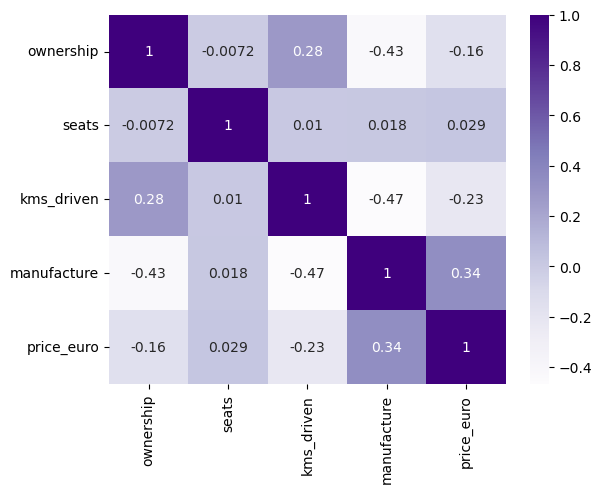

In [31]:
numerical_features = ["ownership", "seats", "kms_driven", "manufacture", "price_euro"]
sns.heatmap(df[numerical_features].corr(), cmap="Purples", annot=True)

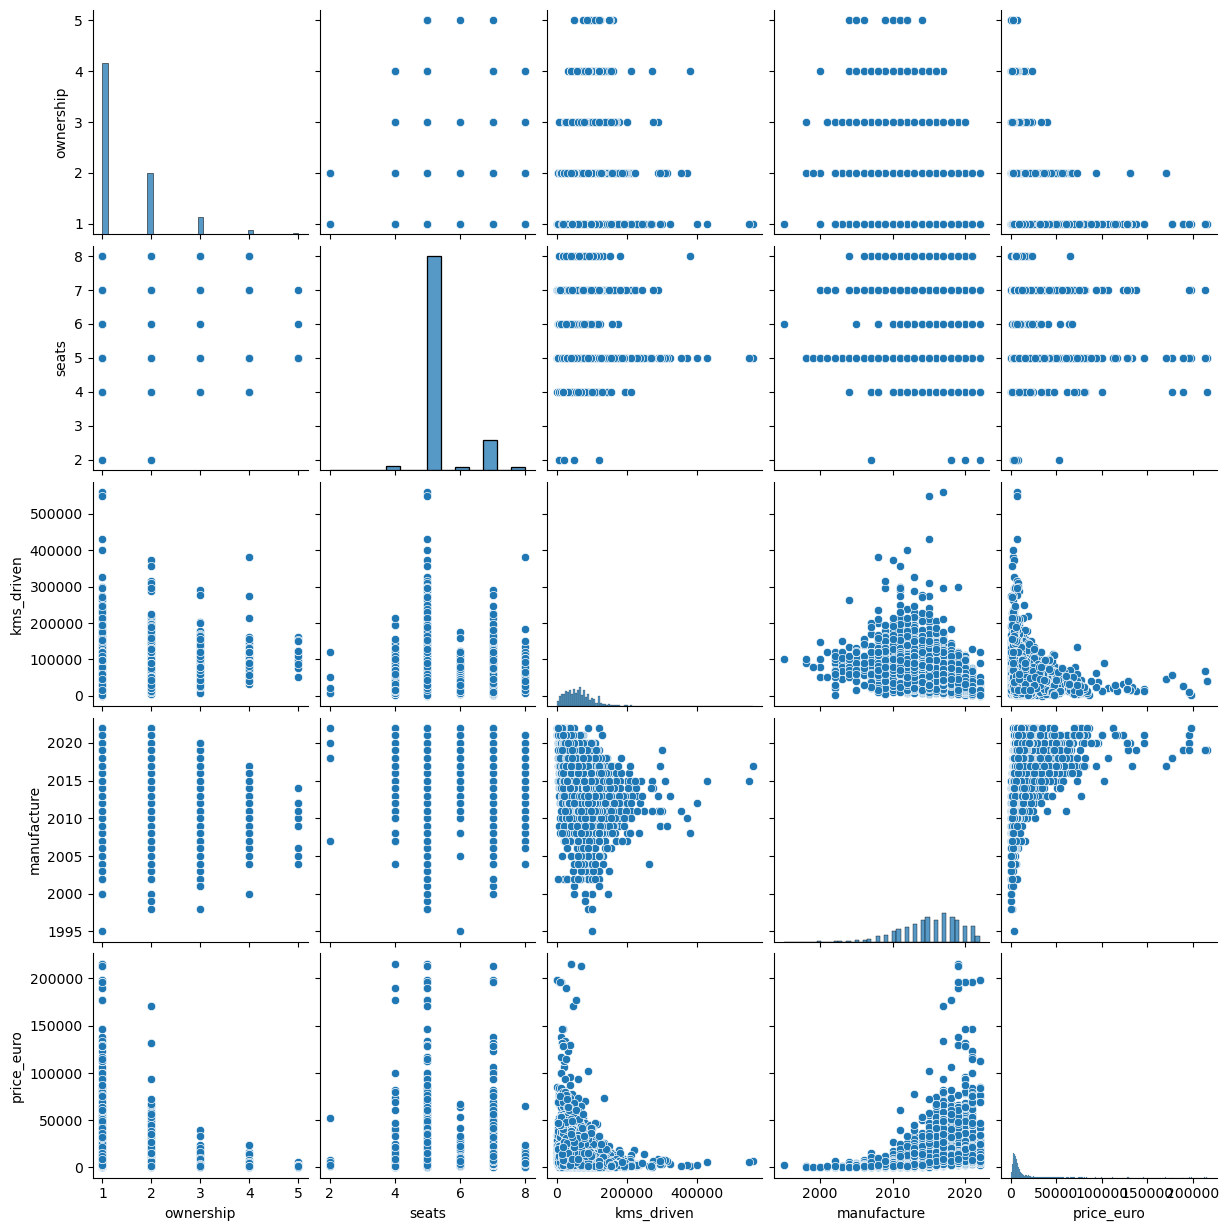

In [32]:
sns.pairplot(data=df, vars=numerical_features)

Distribution of price

<Axes: ylabel='Frequency'>

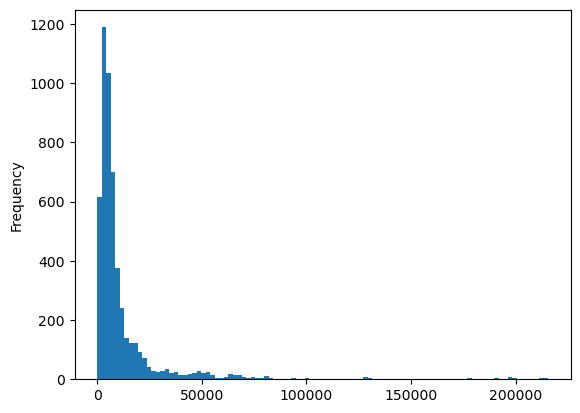

In [33]:
df["price_euro"].plot(kind="hist", bins=100)

In [34]:
df = df.drop(df[df["price_euro"] > 80000].index)

In [35]:
df["car_name"] = df["car_name"].str.split().str[0]
df["car_name"].unique()

array(['Jeep', 'Renault', 'Toyota', 'Honda', 'Volkswagen', 'Maruti',
       'Mahindra', 'Hyundai', 'Nissan', 'Kia', 'MG', 'Tata', 'BMW',
       'Mercedes-Benz', 'Datsun', 'Volvo', 'Audi', 'Porsche', 'Ford',
       'Chevrolet', 'Skoda', 'Lexus', 'Mini', 'Jaguar', 'Land',
       'Mitsubishi', 'Force', 'Premier', 'Fiat', 'Maserati', 'Bentley',
       'Isuzu'], dtype=object)

Text(0.5, 0, 'price in euro')

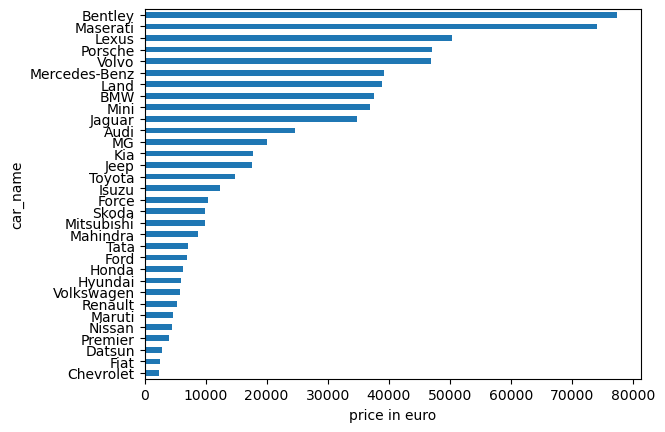

In [36]:
grouped = df.groupby("car_name")["price_euro"].mean().sort_values()
grouped.plot(kind="barh").set_xlabel("price in euro")

In [37]:
car_counts = df["car_name"].value_counts().sort_values(ascending=True)
car_counts

car_name
Force               1
Premier             1
Bentley             1
Maserati            2
Isuzu               4
Porsche             5
Mitsubishi          8
Lexus               8
Mini               13
Fiat               17
Jaguar             21
Land               24
Datsun             25
Volvo              26
Jeep               47
MG                 59
Kia                60
Nissan             63
Chevrolet          82
Skoda             111
BMW               128
Audi              134
Volkswagen        153
Renault           164
Ford              164
Mercedes-Benz     200
Toyota            243
Tata              263
Mahindra          305
Honda             479
Hyundai           989
Maruti           1353
Name: count, dtype: int64

In [38]:
cars_to_keep = car_counts[car_counts >= 8].index
df = df[df["car_name"].isin(cars_to_keep)]

Text(0.5, 0, 'price in euro')

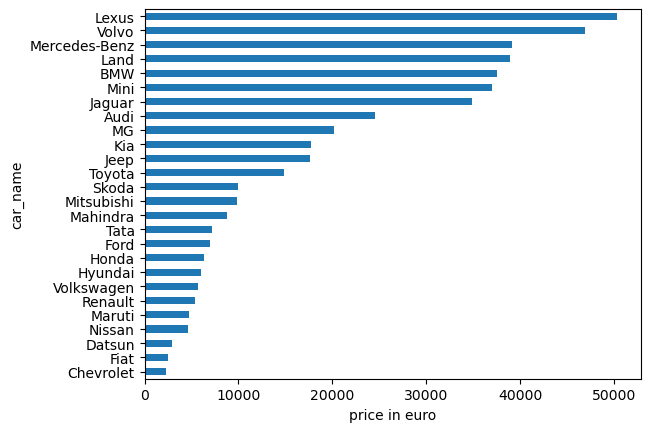

In [39]:
grouped = df.groupby("car_name")["price_euro"].mean().sort_values()
grouped.plot(kind="barh").set_xlabel("price in euro")

In [40]:
bins = [0, grouped.quantile(0.33), grouped.quantile(0.66), grouped.max()]
labels = ["low", "medium", "high"]
categories = pd.cut(grouped, bins=bins, labels=labels)
df["car_brand_price_range"] = df["car_name"].map(categories.to_dict())
df

,car_name,price_euro,kms_driven,fuel_type,is_automatic,ownership,manufacture,seats,engine_cat,car_brand_price_range
0,Jeep,11263.69,86226.0,Diesel,0,1,2017,5.0,medium,medium
1,Renault,14408.09,13248.0,Petrol,1,1,2021,5.0,medium,low
2,Toyota,18417.20,60343.0,Petrol,1,1,2016,5.0,high,medium
3,Honda,8725.71,26696.0,Petrol,1,1,2018,5.0,low,low
4,Volkswagen,5783.45,69414.0,Petrol,0,1,2016,5.0,low,low
...,...,...,...,...,...,...,...,...,...,...
5431,BMW,32454.70,45000.0,Diesel,1,1,2018,7.0,high,high
5432,BMW,72882.70,29000.0,Petrol,1,2,2015,5.0,medium,high
5433,Jaguar,15441.25,90000.0,Diesel,1,2,2013,5.0,high,high
5434,BMW,33577.70,79000.0,Diesel,1,3,2015,6.0,high,high


Normalization with Z-score and removing outliers

In [41]:
normalize_features = ["kms_driven", "manufacture"]

for feature in normalize_features:
    df[feature] =  (df[feature]-df[feature].mean()) / df[feature].std()

In [42]:
for feature in normalize_features:
    df = df.drop(df[(df[feature] > 3) | (df[feature] < -3)].index)

Removing seats because it's not important for the price prediction

In [43]:
df = df.drop("seats", axis=1)

Dropping duplicates that are caused by dropping seats

In [44]:
df[df.duplicated()].shape[0]

51

In [45]:
df = df.drop_duplicates()

In [46]:
df.head(5)

,car_name,price_euro,kms_driven,fuel_type,is_automatic,ownership,manufacture,engine_cat,car_brand_price_range
0,Jeep,11263.69,0.510479,Diesel,0,1,0.435585,medium,medium
1,Renault,14408.09,-1.218839,Petrol,1,1,1.452957,medium,low
2,Toyota,18417.20,-0.102856,Petrol,1,1,0.181242,high,medium
3,Honda,8725.71,-0.900169,Petrol,1,1,0.689928,low,low
4,Volkswagen,5783.45,0.112095,Petrol,0,1,0.181242,low,low


In [47]:
dic_fuel_type = {"Lpg": 0, "Cng": 1, "Petrol": 2, "Electric": 3, "Diesel": 4}
dic_engine_cat = {"low": 0, "medium": 1, "high": 2}
dic_car_brand_price_range = {"low": 0, "medium": 1, "high": 2}

df["fuel_type"] = df["fuel_type"].map(dic_fuel_type)
df["engine_cat"] = df["engine_cat"].map(dic_engine_cat)
df["car_brand_price_range"] = df["car_brand_price_range"].map(dic_car_brand_price_range)

In [48]:
df

,car_name,price_euro,kms_driven,fuel_type,is_automatic,ownership,manufacture,engine_cat,car_brand_price_range
0,Jeep,11263.69,0.510479,4,0,1,0.435585,1,1
1,Renault,14408.09,-1.218839,2,1,1,1.452957,1,0
2,Toyota,18417.20,-0.102856,2,1,1,0.181242,2,1
3,Honda,8725.71,-0.900169,2,1,1,0.689928,0,0
4,Volkswagen,5783.45,0.112095,2,0,1,0.181242,0,0
...,...,...,...,...,...,...,...,...,...
5431,BMW,32454.70,-0.466430,4,1,1,0.689928,2,2
5432,BMW,72882.70,-0.845573,2,1,2,-0.073101,1,2
5433,Jaguar,15441.25,0.599909,4,1,2,-0.581787,2,2
5434,BMW,33577.70,0.339248,4,1,3,-0.073101,2,2


Neural Network

In [49]:
class NN(nn.Module):
    def __init__(self, in_features=7, h1=8, h2=8, out_features=1): # Features: kms_driven, fuel_type, is_automatic, ownership, manufacture, engine_cat, car_brand_price_range
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x

In [50]:
features = [ "kms_driven", "fuel_type", "is_automatic", "ownership", "manufacture", "engine_cat", "car_brand_price_range"]

X = df[features]
y = df["price_euro"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

Mean absolute error  3151.37353515625
20241.75		18810.25
4136.57		4087.72
4875.90		3369.00
4407.42		1516.05
4700.03		6344.95
3852.96		10387.75
3973.68		4390.93
7788.26		7007.52
17717.81		13082.95
8821.08		5502.70
6054.41		5974.36
38559.66		33128.50
3761.18		5019.81
3436.60		35.00
8545.96		12375.46
27534.16		41551.00
3693.82		3818.20
15960.90		8310.20
8622.48		6120.35
16943.33		21898.50
4809.90		6457.25
14196.86		11016.63
3124.11		3930.50
7876.50		6097.89
20824.43		17473.88
4101.32		3256.70
22295.72		28917.25
7393.31		6401.10
11105.15		7299.50
12651.90		21482.99
11960.90		15935.37
3369.59		6457.25
8105.15		8355.12
12426.91		10949.25
945.43		2526.75
4549.82		5221.95
4768.11		5615.00
5013.58		5570.08
945.43		1459.90
2424.90		2246.00
2636.01		1617.12
8163.84		8467.42
39330.07		44863.85
4991.00		3941.73
49204.68		30208.70
12279.33		13476.00
24096.96		18181.37
7141.06		5716.07
9521.50		31500.15
2871.63		1459.90
12024.25		17833.24
11208.97		8321.43
3648.86		2796.27
52861.30		49412.00
6329.50	

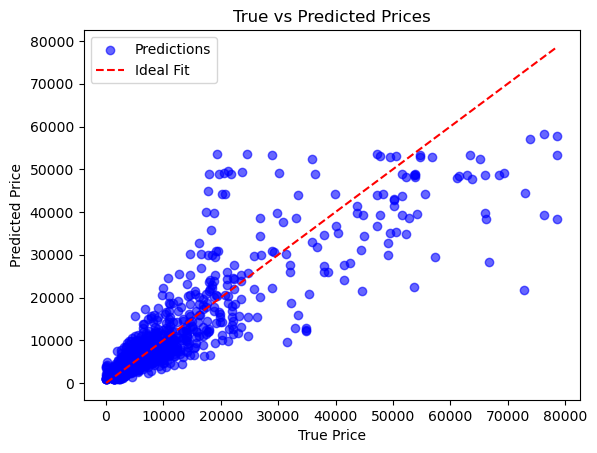

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NN().to(device)

lr = 0.1
batch_size = 50
epochs = 109

tensor_dataset_train = TensorDataset(X_train, y_train)
tensor_dataset_test = TensorDataset(X_test, y_test)
train_dataLoader = DataLoader(tensor_dataset_train, batch_size)
test_dataLoader = DataLoader(tensor_dataset_test, batch_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

for epoch in range(epochs):
    for X_train_batch, y_train_batch in train_dataLoader:
        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        y_pred = model.forward(X_train_batch)
        loss = criterion(y_pred, y_train_batch)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()



model.eval()
predictions = []
true_prices = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataLoader:
        X_test_batch = X_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        X_test_batch = X_test_batch.reshape(X_test_batch.shape[0], -1)

        y_pred = model(X_test_batch)
        predictions.append(y_pred.cpu())
        true_prices.append(y_test_batch.cpu())


predictions = torch.cat(predictions, dim=0).numpy()
true_prices = torch.cat(true_prices, dim=0).numpy()

print("Mean absolute error ", mean_absolute_error(predictions, true_prices))
for pred, true in zip(predictions, true_prices):
    print(f"{pred[0]:.2f}\t\t{true[0]:.2f}")

plt.scatter(true_prices, predictions, alpha=0.6, color="blue", label="Predictions")
plt.plot([min(true_prices), max(true_prices)], [min(true_prices), max(true_prices)], 'r--', label="Ideal Fit")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted Prices")
plt.legend()
plt.show()